# Matrix Completion
This Jupyter notebook will serve as a simple documentation of how we might use matrix completion to 
produce recommendations for jokes. Matrix completion is a specific instance of a broader class of methods
called Collaborative Filtering wherein the aggregation of multiple users' interests in a certain fields is
used to produce predictions for those users in other related fields.

In the context of our problem, we have a collection of jokes and users, and a matrix indexed by users and jokes filled
with the ratings a user has given to each joke. The addition of a new user corresponds to the addition of a new row to the matrix and we would like to estimate the ratings for this user. Now clearly without any information about the user's preferences, this entire process is futile, so we will first probe the user for his preferences on a sample of jokes. Then using this information, we will try to predict his preferences for all the jokes using a matrix completion algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

In [3]:
%matplotlib notebook

In [4]:
import matrix_complete
import matrix_utils
import metrics

In [5]:
from importlib import reload

In [6]:
import user
raters, ratings, jokes = user.old_read_clean_data("jokedb.sqlite3")

In [7]:
raters.select_dtypes('object').columns

Index(['gender', 'birth_country', 'major', 'preferred_joke_genre',
       'preferred_joke_genre2', 'preferred_joke_type', 'favorite_music_genre',
       'favorite_movie_genre'],
      dtype='object')

In [8]:
class MultiLabelBinarizer:
    def __init__(self, columns=None):
        self.columns = columns
        self.binarizers = {}
   
    def binarize_column(self, input_frame, output_frame, column):
        data = input_frame[column]
        binarizer = LabelBinarizer()
        binarizer.fit(data)
        self.binarizers[column] = binarizer
        encoding = binarizer.transform(data)
        for i in range(encoding.shape[1]):
            column_name = binarizer.classes_[i]
            output_frame[column_name] = encoding[:,i]
        output_frame.drop(columns=[column], inplace=True)

    def transform(self, X):
        output_df = X.copy()
        
        if self.columns is not None:
            for column in self.columns:
                self.binarize_column(X, output_df, column)
        else:
            for column in X.columns:
                self.binarize_column(X, output_df, column)
        return output_df

    def fit_transform(self, X):
        return self.transform(X)

In [9]:
from sklearn.model_selection import LeaveOneOut

In [10]:
def k_closest(matrix, row, k):
    errors = (matrix - row) ** 2
    mses = np.nanmean(errors, axis=1)
    indices = np.argpartition(mses, k)[:k]
    return matrix[indices,:]

# The Data


In [11]:
ratings

joke_id,505,506,507,508,509,511,512,513,514,515,...,655,658,659,660,661,663,664,665,666,667
joke_rater_id,,,,,,,,,,,,,,,,,,,,,
453,2.0,4.0,2.0,3.0,1.0,2.0,3.0,3.0,4.0,3.0,...,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0
457,3.0,5.0,3.0,3.0,5.0,3.0,4.0,4.0,5.0,5.0,...,1.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,1.0,4.0
458,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,...,1.0,4.0,1.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0
459,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
460,4.0,4.0,5.0,2.0,2.0,4.0,2.0,3.0,4.0,5.0,...,4.0,4.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0
461,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,3.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0
462,1.0,2.0,4.0,4.0,1.0,4.0,3.0,2.0,4.0,4.0,...,2.0,1.0,3.0,2.0,3.0,1.0,4.0,5.0,4.0,4.0
463,3.0,4.0,2.0,4.0,4.0,2.0,3.0,4.0,4.0,4.0,...,1.0,2.0,2.0,2.0,4.0,5.0,3.0,3.0,3.0,5.0
464,2.0,3.0,5.0,5.0,1.0,5.0,3.0,4.0,3.0,2.0,...,1.0,3.0,1.0,5.0,1.0,5.0,1.0,3.0,1.0,4.0


First let us look at the data. We initially have a ratings matrix as mentioned before.
We can get a visualization of the data very easily using `matplotlib` to display the ratings.

<IPython.core.display.Javascript object>


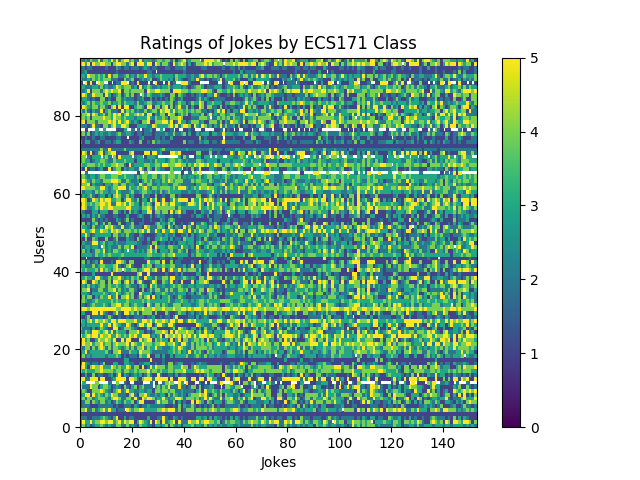

Text(0.5,1,'Ratings of Jokes by ECS171 Class')

In [12]:
fig, axis = plt.subplots()
heatmap = axis.pcolor(ratings.values)
fig.colorbar(heatmap)
axis.set_xlabel('Jokes')
axis.set_ylabel('Users')
axis.set_title('Ratings of Jokes by ECS171 Class')

A couple of things worth noting. Remember that users are along the y-axis and jokes along the x-axis.
The jokes are rated on a scale from 1-5. However, this does not mean all the users used the same scale for their jokes,
nor did they rate every joke. As can be seen from the white spots in the matrix, some users did not rate every joke.
Also, some users were much harsher with their ratings (as evidenced by the blue horizontal streaks) and others were much more lenient (seen in horizontal yellow streaks).

This is more easily seen by looking at a subset of the matrix.

<IPython.core.display.Javascript object>


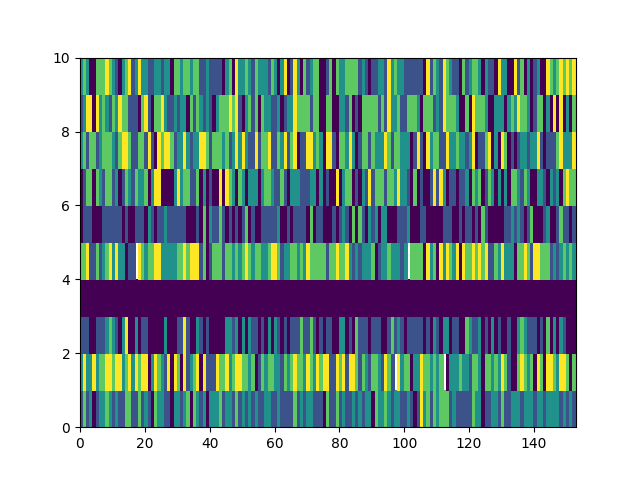

In [13]:
fig, axis = plt.subplots()
axis.pcolor(ratings.values[:10])

Here we see that one user rated every single joke a 1 meaning either he has no sense of humor, no joke was funny, or he did not care to rate the jokes properly. 
In any case these strict raters may play a significant role in how predictions are made. Not sure yet.

# Testing the Method
To examine how our method works, we will take sample rows from our already existing data set and eliminate all but a couple ratings. These uneliminated ratings will represent the jokes which we recommend to the new user and expect them to rate. Then we will apply the matrix completion to the new matrix with the entries removed.

In [14]:
import metrics
import random

In [15]:
def scale(array):
    a, b = min(array), max(array)
    return ((array - a) / (b - a)) * 4 + 1

To test our method, we want to pick some interesting rows to see how the method acts on a variety of cases. To see how
it works, we will examine its performance on a row with low ratings, average ratings, and high ratings. To this end,
we pick rows with a low mean rating, middle mean rating and high mean rating.

In [16]:
ratings_matrix = ratings.values
m, n = ratings_matrix.shape
masked = np.ma.array(ratings_matrix, mask=np.isnan(ratings_matrix))

In [17]:
means = np.mean(masked, axis=1)
bad = np.argmin(np.mean(masked, axis=1))
avg = np.argpartition(means, 50)[50]
good = np.argpartition(means, 90)[90]

/home/dominic/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: UserWarning: Warning: 'argpartition' will ignore the 'mask' of the MaskedArray.
  return getattr(obj, method)(*args, **kwds)


What these rows look like is pictured here. Note we picked a row where the user rated all 1s. We also picked a row where the user rated many jokes highly. The second row there is quite a good variety of ratings.

<IPython.core.display.Javascript object>


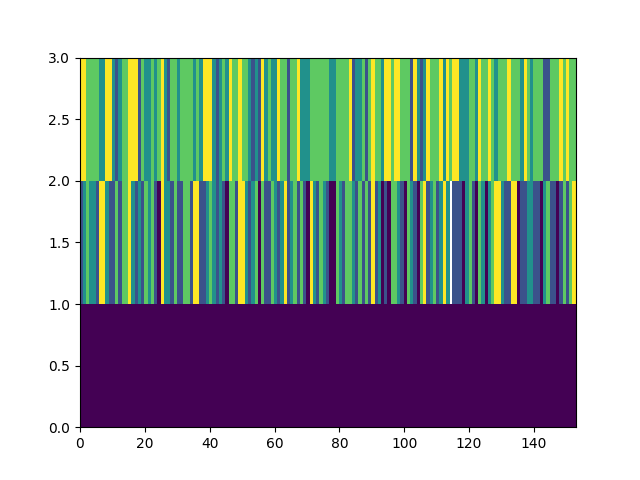

In [18]:
fig, ax = plt.subplots()
ax.pcolor(ratings_matrix[[bad, avg, good]])

We now define a couple of methods to perform the tests using matrix completion. We also would like to define a mean square error estimator to get a quantitative estimate for the performance of the methods.

In [23]:
def clear_row(row, sample_size):
    """
    Drop a number of entries from the row. This removes all but sample_size number of entries from
    the row. This will return a copy of the row with the entries removed.
    
    Args:
        row (np.array): A row of the ratings matrix
        sample_size (int): The desired amount of ratings to remain after dropping entries
    """
    row_copy = row.copy()
    for i in random.sample(list(range(n)), n-sample_size):
        row_copy[i] = np.nan
    return row_copy

def complete_row(row, row_index, method):
    """
    This will run the matrix completion method with the passed in row replacing the row at row_index
    in the ratings matrix. This will return the completed row filled after matrix completion.
    
    Args:
        row (np.array): A row with missing entries to be completed
        row_index (int): The index of the row in the matrix
        method (str): The specific matrix completion method
    """
    matrix_copy = ratings_matrix.copy()
    matrix_copy[row_index] = row
    complete = matrix_complete.complete_matrix(matrix_copy, method)
    return complete[row_index]

In [24]:
def generate_rows(row_index, sample_size):
    """
    This will clear all but a sample of entries from the specified row index. Then for each of the
    matrix completion methods, it will complete the specific row. It will compile each of the completed
    rows in a list. The first two elements of the list will be the original row and then the row with
    all but the sample of elements removed.
    """
    row = ratings_matrix[row_index]
    cleaned_row = clear_row(row, sample_size)
    rows = [row, cleaned_row]
    for method in methods:
        rows.append(complete_row(cleaned_row, row_index, method))
    return rows

def plot_methods(rows):
    fig, ax = plt.subplots()
    mat = np.vstack(rows[::-1])
    heatmap = ax.pcolor(np.clip(mat, 1, 5))
    fig.colorbar(heatmap)
    ax.set_xlabel('Jokes')
    ax.set_ylabel('Matrix Completion Methods')
    ax.set_title('Performance of different Matrix Completion Methods')

def mean_square_errors(rows):
    """
    This will compute the mean square errors for each of the methods and return them in a list.
    This function expects a list of the rows as produced by the generate_rows method.
    Hence the first element is the original row, the second the cleared row, and the rest the
    rows generated by each of the methods.
    """
    errors = []
    for row in rows[2:]:
        errors.append(np.nanmean((rows[0] - row)**2))
    return errors

def print_errors(errors):
    print("Error Report")
    for method, error in zip(methods, errors):
        print("Method {}: {}".format(method, error))

### The different methods
Now that we have a collection of simple functions for generating complete rows, we can discuss the separate methods
of matrix completion, and actually test them out. These are all methods which are drawn from the `fancyimpute` library.

The simpler methods simply take a the single column for a missing entry into account. These are the **mean**, **median**, and **gauss**, which fill missing entries with the mean, median, or randomly generated value from a gaussian distribution fitted to the column.

The **KNN** method takes the K (currently 5) nearest users (measured in terms of mean square difference of observed ratings) and uses these closer users to complete the matrix.

The **Soft Impute**, **Iterative SVD**, and **Nuclear Norm Minimization** methods use higher level linear algebra methods involving singular value decompositions or other techniques to try to fill the entries while minimizing the rank (in effect not trying to introduce too much information). Also these are complicated and I don't quite understand them. To use them would necessitate further research and reading the associated papers.

In [25]:
methods = ['mean', 'median', 'soft_impute', 'iterativeSVD',
           'nuclear_norm_minimization', 'KNN',
           'gauss']

Now using each of these methods we can test each of the methods against our sample rows. We first generate a row
for each of the methods.

In [26]:
bad_rows = generate_rows(bad, 10)
avg_rows = generate_rows(avg, 10)
good_rows = generate_rows(good, 10)

For the plots, we note that the order of the rows of the depicted matrix are as follows:

1. Original Row
1. Cleaned Row
1. Mean
1. Median
1. Soft Impute
1. IterativeSVD
1. NuclearNormMin
1. KNN
1. Gauss

First we present the generated rows for the user who rated everything 1s.

<IPython.core.display.Javascript object>


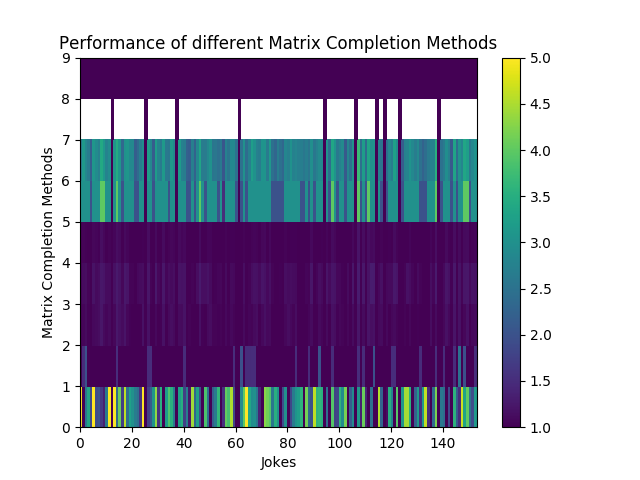

In [27]:
plot_methods(bad_rows)

First we note that the mean, median, and gauss method are clearly way off since they do not take into account the sampled
jokes. They simply look similar to the column of ratings itself which for this pessimistic user is very different from the average rating. The other methods seem able to capture that this user will rate everything 1.

We now present the mean square error estimates for each of the methods.

In [28]:
bad_errors = mean_square_errors(bad_rows)
print_errors(bad_errors)

Error Report
Method mean: 3.0679259589876726
Method median: 3.295751633986928
Method soft_impute: 0.003053472104579588
Method iterativeSVD: 0.018351484643201476
Method nuclear_norm_minimization: 0.008141835687754987
Method KNN: 0.08333329763093923
Method gauss: 4.4103123739533725


We now present the plot and associated errors for the average row of ratings. Note that the **mean** method performs much
better here as the ratings are much closer to average. Also note that the ratings produced are very heavily dependent on which samples are chosen. It may be that the samples are rated unusually high compared to the user's typical ratings and so this throws off the rest of the predicted ratings. This only suggests the significance of picking representative samples.

<IPython.core.display.Javascript object>


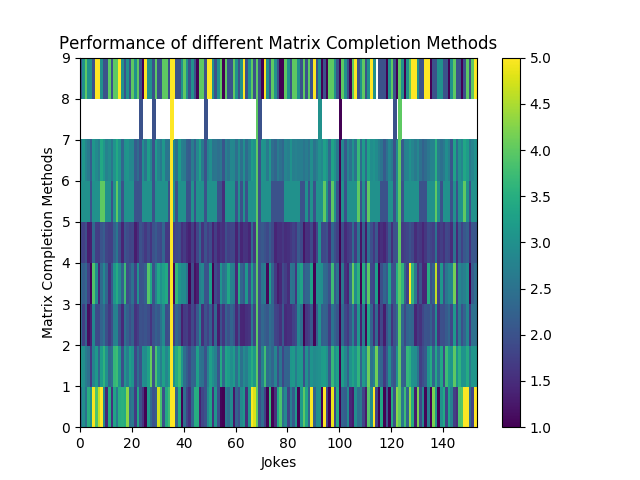

In [29]:
plot_methods(avg_rows)

In [30]:
avg_errors = mean_square_errors(avg_rows)
print_errors(avg_errors)

Error Report
Method mean: 1.4000786080436718
Method median: 1.5279605263157894
Method soft_impute: 2.6275548971523603
Method iterativeSVD: 2.047157589585872
Method nuclear_norm_minimization: 2.348697139506053
Method KNN: 1.5054117697985925
Method gauss: 3.172498505169825


We now present the plots and errors for the user who has very high ratings.

<IPython.core.display.Javascript object>


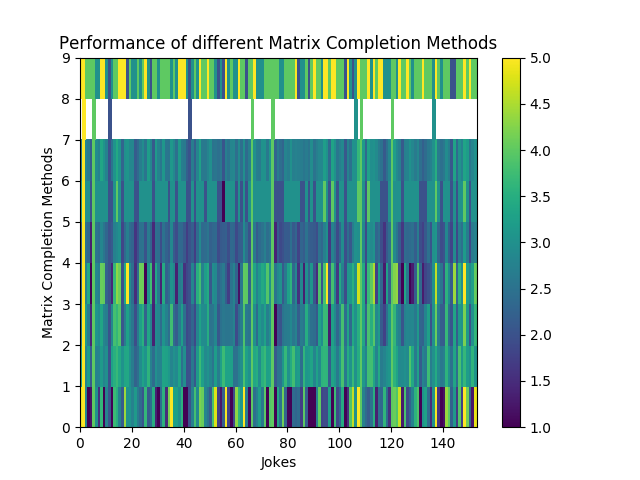

In [31]:
plot_methods(good_rows)

In [32]:
good_errors = mean_square_errors(good_rows)
print_errors(good_errors)

Error Report
Method mean: 1.7521623545402336
Method median: 1.7581699346405228
Method soft_impute: 2.8672443759500568
Method iterativeSVD: 2.321598644310025
Method nuclear_norm_minimization: 1.8764017445678396
Method KNN: 1.3296177206261541
Method gauss: 3.372439700060273


# Where to go from here
This was simply a brief examination of a collection of methods that completed the matrix of ratings.
There are many more avenues of further study which can be continued from this starting point.
These include:
1. Methods of picking representative samples
2. Considering a subset of similar users to run a matrix completion algorithm on
3. How active learning could be used to proactively update the matrix
4. Other Matrix Completion Methods
5. Something entirely different???